# CISCO COMMENT CATEGORIZATION

#### LOADING DEPENDENCIES

In [2]:
import nltk
from collections import Counter
import math
import pickle
from collections import OrderedDict
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import string

#### LOADING COMMENTS

In [3]:
data = pickle.load( open( "comments", "rb" ) ,encoding='latin1')
comments = data['comments']

In [4]:
documents = []
for comment in comments:
    str_comment  = ''
    for sentence in comment:
        str_comment += sentence  
    documents.append(str_comment)

In [5]:
documents[1]

'Hello,I will try to build a small LAB for my studies (including CCNA and CCNP certification) but I am surrounded by 2 questions.1-Is this equipment sufficient for a LAB in order to pass certifications CCNA and CCNP ?2-Can I use a etherswitch (NM-16ESW) as a normal switch to link it at computer, D-Link Switch etc...If not, what type of modul I need to use ?Otherwise, can I also use it as a WAN socket like the 2 sockets already here in the Cisco router 1821 ?My existing equipments :-D-Link Switch DGS-1216T 16 port 10/100/1000 (actually in use, but full)-My PC (for test ^^)-A Server with 6 Ethernet sockets (for VMs with VMware, 16 core 72Go RAM)-My Bouygue router (given by my FAI, in french)-A 4G router of Huawei (better than my adsl ^^)The equipments that I want to buy to try it and for my studies :-Cisco router 2821 -Cisco router 1821 -Cisco Switch WS-C2960G-24TC-L (24 ports 10/100/1000 to replace my D-link)Sincerely Thomas'

#### COMMENT PRE - PROCESSING

In [6]:
def comment_cleaner(comment):
    
    words = nltk.word_tokenize(comment)
    words = [word.lower() for word in words if word.isalpha()]
    table = str.maketrans('', '', string.punctuation)
    words = [word.translate(table) for word in words]
    words = [word for word in words if word.isalpha()]
    
    word_tags = nltk.pos_tag(words)
    
    words = [word for word,tag in word_tags if tag in ('NN','JJ','NNP','NNS','NNPS')]
    #words.extend([word[-1] for word,tag in word_tags if tag in ('NNS','NNPS')])
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]
    # stemming of words
    #lemma = nltk.stem.wordnet.WordNetLemmatizer()
    #words = [lemma.lemmatize(word) for word in words]
        
    #porter = PorterStemmer()
    #words = [porter.stem(word) for word in words]
    cleaned_comment = ' '.join(words)
    
    return cleaned_comment

In [7]:
comment_cleaner(documents[1])

'hello small lab studies ccna ccnp certification equipment sufficient lab order certifications ccna ccnp etherswitch normal switch computer switch etc type modul wan socket sockets cisco router equipments port use full pc test server ethernet sockets vms vmware core ram bouygue router fai french router huawei adsl equipments studies router switch ports'

In [8]:
cleaned_comments = []

for i in range(len(documents)):
    cleaned_comments.append(comment_cleaner(documents[i]))

In [9]:
len(cleaned_comments)

351

In [10]:
all_comments = " ".join(cleaned_comments)
all_words = all_comments.split()
len(all_words)

42157

#### FINDING THE MOST FREQUENT WORDS IN CORPUS


In [11]:
most_common = Counter(all_words).most_common(25)[1:]
print(most_common)

[('ip', 811), ('action', 591), ('interface', 524), ('command', 493), ('address', 453), ('cli', 397), ('switch', 360), ('vlan', 335), ('cisco', 333), ('router', 303), ('network', 257), ('access', 249), ('port', 228), ('config', 197), ('mode', 177), ('configuration', 176), ('default', 170), ('event', 164), ('dhcp', 156), ('traffic', 147), ('host', 140), ('enable', 139), ('server', 138), ('switchport', 133)]


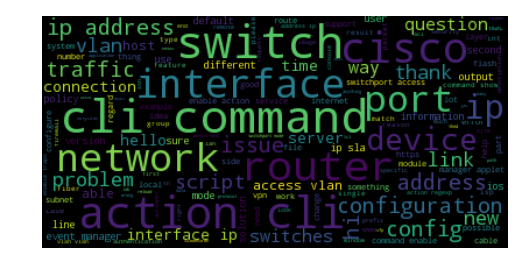

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)


wordcloud = WordCloud(
                          background_color='black',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(all_comments)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### CREATING WORD EMBEDDING TO FIND SIMILAR WORDS



In [14]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
from gensim.models import Word2Vec
sentences = [cleaned_comment.split() for cleaned_comment in cleaned_comments]
model = Word2Vec(sentences,min_count = 1)

In [34]:
print(model)
words = list(model.wv.vocab)
len(words)

Word2Vec(vocab=4855, size=100, alpha=0.025)


4855

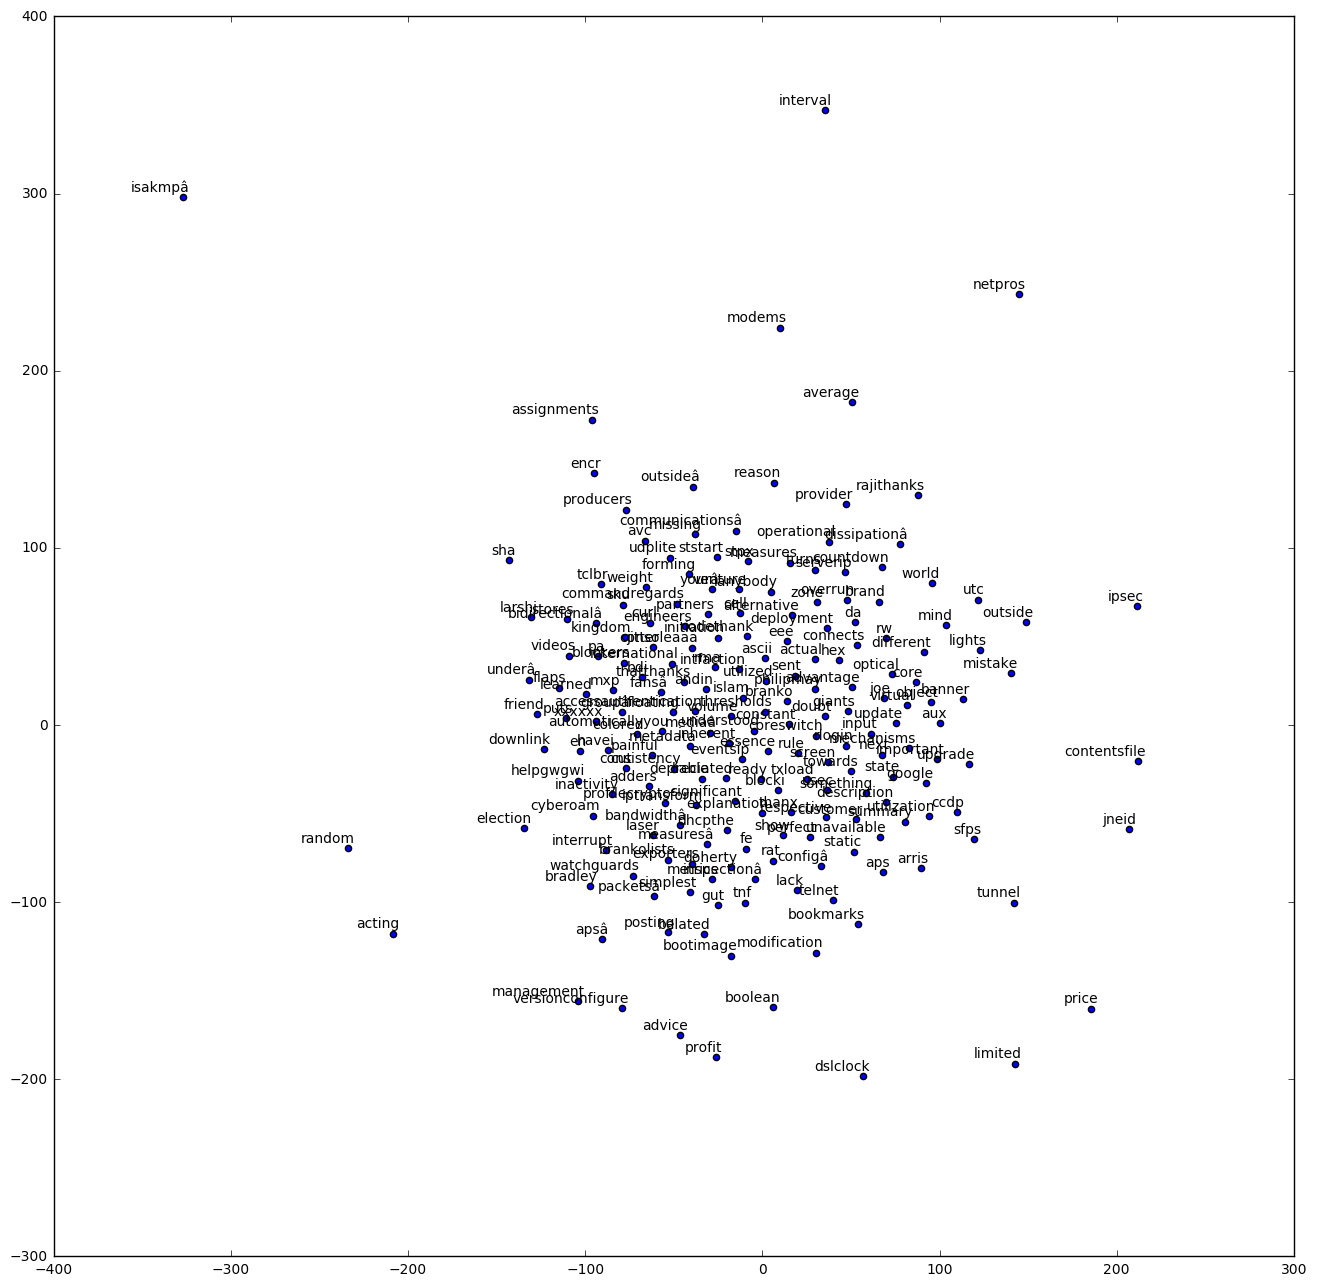

In [35]:
from sklearn.manifold import TSNE
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in words[:200]:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    
    
tsne_plot(model)

In [16]:
model.most_similar("vlan",topn=5)

[('access', 0.9998863935470581),
 ('shutdown', 0.9994217157363892),
 ('ip', 0.9983746409416199),
 ('regexp', 0.998306930065155),
 ('gigabitethernet', 0.9977118372917175)]

#### FINDING SET OF SIMILAR WORDS TO MOST FREQUENT WORDS FOR COMMENT CLASSIFICATION

In [17]:
most_similar = dict()
for i in range(len(most_common)):
    
    sim_words = model.most_similar(most_common[i][0],topn=7)
    
    most_similar[most_common[i][0]] = [word for word,_ in sim_words]

In [18]:
for key,_list in most_similar.items():
    print("\t"+key + "\t\t:\t"+str(_list))

	cisco		:	['problem', 'link', 'cable', 'support', 'regards', 'service', 'hi']
	access		:	['vlan', 'shutdown', 'ip', 'regexp', 'description', 'match', 'pattern']
	host		:	['mc', 'seq', 'tcp', 'static', 'eq', 'outside', 'cdp']
	cli		:	['conf', 'action', 'command', 'portfast', 'switchport', 'intfaction', 'iface']
	dhcp		:	['address', 'nat', 'native', 'auto', 'tcp', 'trunk', 'duplex']
	enable		:	['gigabitethernet', 'pattern', 'regexp', 'intf', 'shut', 'downâ', 'intfâ']
	configuration		:	['connection', 'question', 'issue', 'prefix', 'device', 'nexus', 'devices']
	event		:	['manager', 'inc', 'match', 'end', 'applet', 'countdown', 'description']
	network		:	['ports', 'system', 'hardware', 'type', 'share', 'bytes', 'qos']
	interface		:	['intf', 'accessâ', 'gigabitethernet', 'intfâ', 'downâ', 'enable', 'shut']
	mode		:	['destination', 'layer', 'configure', 'tunnel', 'inâ', 'source', 'script']
	default		:	['number', 'id', 'errors', 'internal', 'valid', 'rate', 'input']
	port		:	['switch', 'traff

In [20]:
all_simwords = []
for key,_list in most_similar.items():
    all_simwords.extend(_list)

In [21]:
print(Counter(all_simwords))

Counter({'description': 4, 'regexp': 4, 'conf': 4, 'intf': 4, 'iface': 3, 'isp': 3, 'list': 3, 'gigabitethernet': 3, 'port': 3, 'switch': 3, 'command': 3, 'cli': 3, 'intfâ': 3, 'shut': 3, 'tcp': 3, 'traffic': 3, 'pattern': 3, 'shutdown': 3, 'portfast': 3, 'action': 3, 'router': 3, 'trunk': 2, 'native': 2, 'duplex': 2, 'match': 2, 'vlan': 2, 'access': 2, 'static': 2, 'cdp': 2, 'downâ': 2, 'nat': 2, 'switchport': 2, 'auto': 2, 'test': 2, 'intfaction': 2, 'switches': 2, 'ip': 2, 'link': 1, 'type': 1, 'nexus': 1, 'issue': 1, 'service': 1, 'dhcp': 1, 'autoâ': 1, 'something': 1, 'insideâ': 1, 'countdown': 1, 'id': 1, 'vlanâ': 1, 'hardware': 1, 'profile': 1, 'copy': 1, 'regex': 1, 'eq': 1, 'qos': 1, 'need': 1, 'problem': 1, 'seq': 1, 'space': 1, 'system': 1, 'errors': 1, 'subnet': 1, 'http': 1, 'laptop': 1, 'inc': 1, 'input': 1, 'cable': 1, 'rate': 1, 'applet': 1, 'support': 1, 'bytes': 1, 'enable': 1, 'new': 1, 'subnets': 1, 'ports': 1, 'device': 1, 'management': 1, 'mc': 1, 'share': 1, 'man

In [25]:
comment_with_simwords = []
for i in range(len(cleaned_comments)):
    current_comment = cleaned_comments[i].split()
    current_comment = [word for word in current_comment if word in all_simwords]
    comment_with_simwords.append(current_comment)

In [28]:
comment_with_simwords[2]

['hi', 'devices', 'service', 'service', 'service', 'service', 'rate']

In [29]:
cleaned_comments[2]

'hi cisco prime infrastructure error assist operational status job site sync job sites devices information apic pi instance job consecutive ncs status health monitor server role primary state ha configured database server runningftp service runningtftp service runningmatlab server runningmatlab server instance runningnms server daemon da daemon upgrade ncs status health monitor server role primary state ha configured database server gateway runningftp service runningtftp service runningmatlab server runningmatlab server instance runningnms server daemon da daemon hidid application ncs stop application star please rate reply ncs stop ncs cammnd application bundle application reset application configuration factory defaults application stop stop application upgrade application application ststart application start word application name max size application start'